# Analyse Comparative des Tokenizers sur des Données Textuelles Multilingues


## Import des librairies nécessaires au chargement et analyse des données

- os: donne accès utiles pour le chargement des données du dataset
- json: chargement des phrases tokenisées stockées au format json
- pandas: chargement des statistiques sur le dataset ainsi que statistiques issues de wikipedia
- numpy: manipulation de données vectorielles
- scipy: librairie de fonction scientifiques
- iso639: permet la manipulation des codes iso-639 identifiant des langues
- transformers: permet l'utilisation des tokenizers mise à disposition sur [Hugging Face](https://huggingface.co/)
- matplotlib: permet la visualisation de données


In [2]:
# Install from the requirements file
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
import pandas as pd
import numpy as np
import scipy
import iso639
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import plotly.express as px

## Définition des chemins vers les données à charger

- LANG_INFO_PATH: chemin vers le tableau contenant les informations sur les langues dont les phrases ont étés pré-tokenisées
- FLORES_DATASET_PATH: chemin vers le dossier content le jeu de données FLORES-200
- MADLAD_STATS_PATH: chemin vers le tableau contenant les statistiques sur les données utilisées à l'entraînement du modèle MADLAD-400
- WIKI_STATS_PATH: chemin vers le tableau content les statistiques sur wikipedia


In [4]:
LANG_INFO_PATH = './inputs/FLORES-200.lang_info.csv'
FLORES_DATASET_PATH = './inputs/flores200_dataset/'
MADLAD_STATS_PATH = './inputs/madlad_stats.tsv'
WIKI_STATS_PATH = './inputs/wikipedia_stats.csv'

## Selection de la partition de FLORES-200

Le jeu de données FLORES-200 est séparé en deux partition:

- dev
- devtest

La variable `SPLIT` permettent de selectionner la partition à charger.


In [5]:
SPLIT = 'dev'

## Selection des données pré-tokenisées à charger

Le jeu de données FLORES-200 a été tokenisé à l'aide des tokenizer des modèles suivant:

- [NLLB](https://huggingface.co/docs/transformers/model_doc/nllb)
- [MADLAD-400](https://huggingface.co/docs/transformers/model_doc/madlad-400)

La selection du modèle considéré se fait à travers la variable `MODEL`


In [6]:
MODEL = 'madlad' # 'nllb'

Chemin vers le fichier json contenant les données pré-tokenisées:


In [7]:
DATASET_TOKENIZED_PATH = './inputs/FLORES-200.{:}.tokenized.json'.format(MODEL)

## Mise en correspondance du modèle sélectionné avec son identifiant unique

Le code suivant met en correspondance le nom court du modèle utilisé (`MODEL`) avec son identifiant (`MODEL_NAME`) sur Hugging Face.
Cet identifiant sera utilisé plus tard pour charger le tokenizer du modèle sélectionné, ce qui permettra de:

- décoder les phrases pré-tokenisées
- encoder des phrases pour des nouvelles phrases
- avoir accès aux identifiants de token spéciaux, utiles lors de l'analyse des phrases tokenisées


In [8]:
if MODEL == 'madlad':
    MODEL_NAME = 'google/madlad400-3b-mt'
    
elif MODEL == 'nllb':
    MODEL_NAME = 'facebook/nllb-200-3.3B'

## Chargement des informations sur les données pré-calculées

Le tableau csv pointé par `LANG_INFO_PATH` liste les langues pour lesquelles les phrases ont déjà été tokenisées associées avec différentes informations utiles, notamment:

- lang_script: le code iso-639-3 ainsi que le script utilisé, cette combinaison correspondant au nom de fichier dans le jeu de données FLORES-200
- lang_family: la famille à laquelle apartient la langue


In [9]:
lang_info_list = pd.read_csv(LANG_INFO_PATH, sep='\t', index_col=0)

In [10]:
lang_info_list

,lang_name,lang_family,wiki.articles,wiki.activeusers,lang_script
eng,English,Germanic,6821000.0,122498.0,eng_Latn
nld,Dutch,Germanic,2157848.0,3685.0,nld_Latn
ltz,Luxembourgish,Germanic,63344.0,75.0,ltz_Latn
fra,French,Romance,2610187.0,17122.0,fra_Latn
spa,Spanish,Romance,1951111.0,14871.0,spa_Latn
glg,Galician,Romance,206719.0,260.0,glg_Latn
rus,Russian,Balto-Slavic,1978036.0,9570.0,rus_Cyrl
pol,Polish,Balto-Slavic,1613860.0,4371.0,pol_Latn
mkd,Macedonian,Balto-Slavic,143844.0,241.0,mkd_Cyrl


In [11]:
lang_info_list = pd.read_csv(LANG_INFO_PATH, sep='\t', index_col=0)

## Chargement des phrases du dataset


In [12]:
# Initialisation du dictionnaire contenant les phrases du dataset pour chaque langue
dataset = dict()

# Construction du chemin vers le jeu de données à partir de la partition choisie
split_base_path = os.path.join(FLORES_DATASET_PATH, SPLIT)


# Pour chaque langue identifié par l'index du tableau lang_info_list
for lang_id, lang_info in lang_info_list.iterrows():
    
    # Construction du chemin vers le fichier listant les phrases pour la langue "lang_id"
    file_path = os.path.join(split_base_path,  '{:}.{:}'.format(lang_info['lang_script'], SPLIT))

    # Chargement du fichier listant les phrases
    with open(file_path, 'r') as file:
        dataset[lang_id] = file.read().split('\n')

        # Suppression de la dernière ligne vide
        del(dataset[lang_id][-1])


In [13]:
dataset

{'eng': ['On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.',
  'Lead researchers say this may bring early detection of cancer, tuberculosis, HIV and malaria to patients in low-income countries, where the survival rates for illnesses such as breast cancer can be half those of richer countries.',
  'The JAS 39C Gripen crashed onto a runway at around 9:30 am local time (0230 UTC) and exploded, closing the airport to commercial flights.',
  'The pilot was identified as Squadron Leader Dilokrit Pattavee.',
  'Local media reports an airport fire vehicle rolled over while responding.',
  '28-year-old Vidal had joined Barça three seasons ago, from Sevilla.',
  'Since moving to the Catalan-capital, Vidal had played 49 games for the club.',
  "The protest started around 11:00 local t

## Chargement des statistiques sur les wikipedias en différentes langues


In [14]:
wiki_stat_list = pd.read_csv(WIKI_STATS_PATH, sep='\t', index_col=0)

### Nettoyage des statistiques wikipedia

Les lignes ne correspondant pas à un wikipedia d'une langue données sont supprimées et le code iso-639-3 est ajouté


In [15]:
# Ajout de la colonne lang_id correspondant au code iso-639-3 pour les langues du tableau
wiki_stat_list['lang_id'] = ''

# Parcours des identifiants des lignes du tableau
for site_id in wiki_stat_list.index:
    # Suppression de la ligne si elle ne correspond pas à un sous-domaine de wikipedia
    if not site_id.endswith('.wikipedia'):
        wiki_stat_list.drop(site_id, inplace=True)
        continue

    # Extraction du préfix du sous-domaine de wikipedia
    site_prefix = site_id.split('.')[0]
    
    lang_id = None

    # La capture d'exception est nécessaire ici dans le cas ou le prefix n'est pas décodable comme code iso-639
    try:
        # Identification du type de code iso correspondant à la langue
        if len(site_prefix) == 2:
            # iso-639 part 1
            lang_id = iso639.Language.from_part1(site_prefix).part3
            
        elif len(site_prefix) == 3:
            # iso-639 part 3
            lang_id = iso639.Language.from_part3(site_prefix).part3

        else:
            # Trop long pour être un code iso-639
            wiki_stat_list.drop(site_id, inplace=True)
            continue
            
    except Exception as e:
        # Le préfix n'a pas pu être décodé comme code iso-639
        wiki_stat_list.drop(site_id, inplace=True)
        continue

    # Ajout de l'identifiant iso-639 pour le sous-domaine
    wiki_stat_list.loc[site_id, 'lang_id'] = lang_id

### Utilisation du code iso-639 comme index du tableau


In [16]:
wiki_stat_list = wiki_stat_list.reset_index().set_index('lang_id')

In [17]:
wiki_stat_list

,site,activeusers,admins,articles,edits,files,pages,users
lang_id,,,,,,,,
eng,en.wikipedia,122498,859,6821000,1217915962,916729,60616907,47363018
deu,de.wikipedia,17540,174,2907600,243140508,129231,8013071,4363247
fra,fr.wikipedia,17122,146,2610187,214426883,71655,13048096,4919217
spa,es.wikipedia,14871,56,1951111,159497362,0,8163874,7135429
jpn,ja.wikipedia,13019,39,1414671,100071784,4522,4158603,2195449
...,...,...,...,...,...,...,...,...
cho,cho.wikipedia,0,1,6,4220,0,200,1814
hmo,ho.wikipedia,0,1,3,3786,0,128,1580
iii,ii.wikipedia,0,1,3,11653,0,188,2035


## Chargement des statistiques sur les données utilisées à l'entraînement du modèle MADLAD-400


In [18]:
madlad_stat_list = pd.read_csv(MADLAD_STATS_PATH, sep='\t', index_col=0)

In [19]:
madlad_stat_list

,BCP-47,Name,Script,Docs (noisy),Docs (clean),Sents (noisy),Sents (clean),chars (noisy),Chars (clean)
lang_id,,,,,,,,,
eng,en,English,Latn,3.6B,1.8B,87.9B,53.4B,15T,9T
rus,ru,Russian,Cyrl,823M,402.5M,823M,12.4B,3.1T,1.8T
spa,es,Spanish,Latn,476.4M,250.9M,8.3B,4.5B,2.1T,1.1T
fra,fr,French,Latn,384.2M,218.9M,7.9B,5B,2T,1T
deu,de,German,Latn,478.6M,225.1M,11.5B,6B,2.2T,1T
...,...,...,...,...,...,...,...,...,...
noe,noe,Nimadi,Deva,2K,22,2K,2.2K,13.8M,195.3K
nut,nut,Nung (Viet Nam),Latn,29K,67,29K,1.5K,23.5M,184.1K
gyn,gyn,Guyanese Creole English,Latn,32.6K,45,211.7K,2.1K,34.5M,177.7K


## Chargement des données pré-tokenisées

### Structure des données

Les données tokenisées son représentées dans un dictionnaire au format json structuré de la manière suivante:

- dictionnaire des phrases pour chaque langue: `dict<lang_id, list>`
  - liste des phrases tokenisées pour une langue donnée: `list<dict>`
    - données brutes issues du tokenizer pour une phrase donnée: `dict<string, list>`
      - liste des tokens identifiée par la clé `"input_ids"`: `list<list<int>>`
      - masque d'attention identifié par la clé `"attention_mask"`: `list<list<int>>`

### Accès à une phrase tokenisée

L'accès aux tokens générés pour la première phrase en Anglais se fera par exemple de la manière suivante:

```
dataset_tokenized['eng'][0]['input_ids'][0]
```

### Attention

- Les données issues du tokenizer ont été stockées telle quelle en suivant un format de batch, elles sont donc représentées par un tableau imbriqué.
- Des tokens spéciaux ont automatiquement été insérés, il faudra donc les retirer lors de calcul de charactéristiques des phrases tokenisées. Ces tokens sont par exemple:
  - `tokenizer.eos_token_id`: identifiant de début de phrase
  - `tokenizer.eos_token_id`: identifiant de fin de phrase
  - `tokenizer.unk_token_id`: identifiant de token inconnu


In [20]:
with open(DATASET_TOKENIZED_PATH, 'r') as fd:
    dataset_tokenized = json.load(fd)[SPLIT]

In [21]:
dataset_tokenized['eng'][0]['input_ids'][0]

[2868,
 42349,
 806,
 195576,
 820,
 2355,
 1013,
 229297,
 10616,
 13051,
 1014,
 100567,
 223301,
 1013,
 821,
 220706,
 1014,
 811,
 8265,
 136160,
 47763,
 2191,
 1521,
 21019,
 148220,
 1324,
 20932,
 815,
 811,
 853,
 1084,
 29947,
 5869,
 44724,
 2191,
 1521,
 897,
 225345,
 37829,
 12917,
 20279,
 9231,
 29947,
 2691,
 1065,
 202082,
 873,
 7253,
 4673,
 1034,
 807,
 1172,
 807,
 33977,
 37535,
 807,
 2]

## Calcul d'une charactéristique pour une phrase donnée

Cette section montre un exemple de calcul de charactéristique à partir d'une phrase sous forme de chaine de charactères (string) et de sa version tokenisée (list\<int\>).

La charactéristique calculée ici est le nombre de token moyen produit par mot, son calcul est défini dans une fonction afin de pouvoir être réutilisé plus tard.


In [22]:
def compute_token_per_word_ratio(sentence, sentence_token_list):
    # Comptage du nombre de mots
    sentence_word_count = len(sentence.split())
    
    # Comptage du nombre de tokens
    sentence_token_count = len(sentence_token_list)
    
    # Calcul du nombre de tokens produits par mots
    sentence_token_per_word_ratio = sentence_token_count / sentence_word_count

    return sentence_token_per_word_ratio


In [23]:
# Choix de la langue pour la phrase
lang_id = 'eng'

# Choix du numéro de phrase
sentence_index = 0

# Récuperation de la phrase selectionnée
sentence = dataset[lang_id][sentence_index]

# Récupération de la liste des tokens générée pour la phrase
sentence_token_list = dataset_tokenized[lang_id][sentence_index]['input_ids'][0]

# Calcul de la charactéristique
sentence_token_per_word_ratio = compute_token_per_word_ratio(sentence, sentence_token_list)

# Affichage de la charactéristique
sentence_token_per_word_ratio

1.3255813953488371

## Utilisation du tokenizer

Cette section montre comment un tokenizer peut être chargé depuis huggingface et utilisé pour décoder et encoder des phrase.

La [documentation des tokenizer huggingface](https://huggingface.co/docs/transformers/main_classes/tokenizer) peut être utile ici.


### Chargement du tokenizer pour le modèle considéré

la variable MODEL_NAME correspond ici à l'identifiant Hugging Face du modèle pour lequel le tokenizer est chargé, la variable MODEL_NAME peut être remplacée par n'importe quel identifiant de modèle disponible sur Hugging Face.

Par exemple pour charger le tokenizer du modèle Phi-3 de Microsoft:

```
tokenizer = AutoTokenizer.from_pretrained(microsoft/Phi-3-mini-128k-instruct)
```


In [24]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Exemple de décodage d'une phrase


In [25]:
# Choix de la langue pour la phrase
lang_id = 'eng'

# Choix du numéro de phrase
sentence_index = 0

# Récuperation de la liste des tokens pour la phrase selectionnée
sentence_token_list = dataset_tokenized[lang_id][sentence_index]['input_ids'][0]

# Décodage à l'aide du tokenizer
sentence_decoded = tokenizer.decode(sentence_token_list, skip_special_tokens=True)

# Affichage de la phrase décodée
sentence_decoded

'On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.'

### Exemple d'encodage d'une phrase


In [26]:
# Choix de la langue pour la phrase
lang_id = 'eng'

# Choix du numéro de phrase
sentence_index = 0

# Récuperation de la phrase selectionnée
sentence = dataset[lang_id][sentence_index]

# Décodage à l'aide du tokenizer
# L'argument add_special_tokens=False permet d'éviter de générer les tokens spéciaux tel que les tokens de début et fin de phrase
sentence_encoded = tokenizer.encode(sentence, add_special_tokens=False)

# Affichage de la phrase décodée
sentence_encoded

[2868,
 42349,
 806,
 195576,
 820,
 2355,
 1013,
 229297,
 10616,
 13051,
 1014,
 100567,
 223301,
 1013,
 821,
 220706,
 1014,
 811,
 8265,
 136160,
 47763,
 2191,
 1521,
 21019,
 148220,
 1324,
 20932,
 815,
 811,
 853,
 1084,
 29947,
 5869,
 44724,
 2191,
 1521,
 897,
 225345,
 37829,
 12917,
 20279,
 9231,
 29947,
 2691,
 1065,
 202082,
 873,
 7253,
 4673,
 1034,
 807,
 1172,
 807,
 33977,
 37535,
 807]

### Décodage token par token d'une phrase


In [27]:
# Choix de la langue pour la phrase
lang_id = 'eng'

# Choix du numéro de phrase
sentence_index = 0

for token_id in dataset_tokenized[lang_id][sentence_index]['input_ids'][0]:
    decoded_token = tokenizer.decode([token_id], skip_special_tokens=True)
    print('{:}:\t"{:}"'.format(token_id, decoded_token))

2868:	"On"
42349:	"Monday"
806:	","
195576:	"scientist"
820:	"s"
2355:	"from"
1013:	"the"
229297:	"Stanford"
10616:	"University"
13051:	"School"
1014:	"of"
100567:	"Medicine"
223301:	"announced"
1013:	"the"
821:	"i"
220706:	"nvention"
1014:	"of"
811:	"a"
8265:	"new"
136160:	"diagnostic"
47763:	"tool"
2191:	"that"
1521:	"can"
21019:	"sort"
148220:	"cells"
1324:	"by"
20932:	"type"
815:	":"
811:	"a"
853:	"ti"
1084:	"ny"
29947:	"print"
5869:	"able"
44724:	"chip"
2191:	"that"
1521:	"can"
897:	"be"
225345:	"manufactured"
37829:	"using"
12917:	"standard"
20279:	"ink"
9231:	"jet"
29947:	"print"
2691:	"ers"
1065:	"for"
202082:	"possibl"
873:	"y"
7253:	"about"
4673:	"one"
1034:	"U"
807:	"."
1172:	"S"
807:	"."
33977:	"cent"
37535:	"each"
807:	"."
2:	""


### Encodage mot par mot d'une phrase


In [28]:
# Choix de la langue pour la phrase
lang_id = 'eng'

# Choix du numéro de phrase
sentence_index = 0

# Récupération de la phrase
sentence = dataset[lang_id][sentence_index]

# Séparation de la phrase en mots
sentence_word_list = sentence.split()

for word in sentence_word_list:
    word_token_list = tokenizer.encode(word, add_special_tokens=False)
    print('"{:}":\n\t{:}'.format(word, word_token_list))

"On":
	[2868]
"Monday,":
	[42349, 806]
"scientists":
	[195576, 820]
"from":
	[2355]
"the":
	[1013]
"Stanford":
	[229297]
"University":
	[10616]
"School":
	[13051]
"of":
	[1014]
"Medicine":
	[100567]
"announced":
	[223301]
"the":
	[1013]
"invention":
	[821, 220706]
"of":
	[1014]
"a":
	[811]
"new":
	[8265]
"diagnostic":
	[136160]
"tool":
	[47763]
"that":
	[2191]
"can":
	[1521]
"sort":
	[21019]
"cells":
	[148220]
"by":
	[1324]
"type:":
	[20932, 815]
"a":
	[811]
"tiny":
	[853, 1084]
"printable":
	[29947, 5869]
"chip":
	[44724]
"that":
	[2191]
"can":
	[1521]
"be":
	[897]
"manufactured":
	[225345]
"using":
	[37829]
"standard":
	[12917]
"inkjet":
	[20279, 9231]
"printers":
	[29947, 2691]
"for":
	[1065]
"possibly":
	[202082, 873]
"about":
	[7253]
"one":
	[4673]
"U.S.":
	[1034, 807, 1172, 807]
"cent":
	[33977]
"each.":
	[37535, 807]


### Encodage du jeu de données entier à l'aide du tokenizer nouvellement chargé

Cette section montre comment l'ensemble du jeu de données peut être encodé à l'aide du tokenizer nouvellement chargé.

#### Attention

Les données produites ici ne seront pas identiques à celles présentes dans `dataset_tokenized` pour les raisons suivantes:

- L'encodage se fait ici phrase par phrase et non par batch, produisant un liste simple de token (list\<int\>) et non une liste imbriquée (list\<list\<int\>\>)
- l'encodage phrase par phrase ne génére qu'une liste de token et non un dictionnaire contenant la liste de token (`input_ids`) et le masque (`attention_mask`).
- La génération de token spéciaux tel que `tokenizer.eos_token_id` et `tokenizer.bos_token_id` est désactivée

La structure produit aura le format suivant:

- dictionnaire des phrases pour chaque langue: `dict<lang_id, list>`
  - liste des phrases tokenisées pour une langue donnée: `list<list>`
    - liste des tokens: `list<int>`

#### Accès à une phrase tokenisée

L'accès aux tokens générés pour la première phrase en Anglais se fera par exemple de la manière suivante:

```
dataset_tokenized_new['eng'][0]
```

La ou pour les données pré-calculées l'accès se faisait de la manière suivante:

```
dataset_tokenized_new['eng'][0]['input_ids'][0]
```


In [29]:
dataset_tokenized_new = dict()

# Pour chaque langue identifié par l'index du tableau lang_info_list
for lang_id in lang_info_list.index:
    # Insertion de la liste contenant les phrases encodées pour la langue
    dataset_tokenized_new[lang_id] = list()

    # Parcours des phrases pour la langue donnée
    for sentence in dataset[lang_id]:
        # Encodage de la phrase
        sentence_token_list = tokenizer.encode(sentence, add_special_tokens=False)

        # Enregistrement de la liste des tokens
        dataset_tokenized_new[lang_id].append(sentence_token_list)

### Comparaison avec les données pré-calculés


In [30]:
print('Données précalculées:')
print(dataset_tokenized['eng'][0]['input_ids'][0])

Données précalculées:
[2868, 42349, 806, 195576, 820, 2355, 1013, 229297, 10616, 13051, 1014, 100567, 223301, 1013, 821, 220706, 1014, 811, 8265, 136160, 47763, 2191, 1521, 21019, 148220, 1324, 20932, 815, 811, 853, 1084, 29947, 5869, 44724, 2191, 1521, 897, 225345, 37829, 12917, 20279, 9231, 29947, 2691, 1065, 202082, 873, 7253, 4673, 1034, 807, 1172, 807, 33977, 37535, 807, 2]


In [31]:
print('Données fraîchement calculées:')
print(dataset_tokenized_new['eng'][0])

Données fraîchement calculées:
[2868, 42349, 806, 195576, 820, 2355, 1013, 229297, 10616, 13051, 1014, 100567, 223301, 1013, 821, 220706, 1014, 811, 8265, 136160, 47763, 2191, 1521, 21019, 148220, 1324, 20932, 815, 811, 853, 1084, 29947, 5869, 44724, 2191, 1521, 897, 225345, 37829, 12917, 20279, 9231, 29947, 2691, 1065, 202082, 873, 7253, 4673, 1034, 807, 1172, 807, 33977, 37535, 807]


## Mise en pratique

Dans cette section vous devrez utiliser les connaissances acquises dans les sections précédentes et:

- calculer des charactéristiques des phrases du jeu de données
- analyser ces charactéristiques
- visualiser ces charactéristiques


### Calcul de charactéristiques

Remplir le dictionnaire `dataset_features` avec les valeurs d'une charactéristique dont vous aurez défini le calcul


In [32]:
def compute_feature_1(sentence, token_list):
    return len(sentence) * (1 + np.random.rand())


def compute_feature_2(sentence, token_list):
    return len(sentence) * (-1 + np.random.rand())


dataset_feature_list = dict()

dataset_feature_list['feature_1'] = dict()
dataset_feature_list['feature_2'] = dict()

for lang_id in lang_info_list.index:
    dataset_feature_list['feature_1'][lang_id] = list()
    dataset_feature_list['feature_2'][lang_id] = list()

    for sentence, token_list in zip(dataset[lang_id], dataset_tokenized_new[lang_id]):
        sentence_feature_1 = compute_feature_1(sentence, token_list)
        sentence_feature_2 = compute_feature_2(sentence, token_list)
        
        dataset_feature_list['feature_1'][lang_id].append(sentence_feature_1)
        dataset_feature_list['feature_2'][lang_id].append(sentence_feature_2)
        

### Analyse de charactéristiques


In [33]:
# Mise à plat des données
dataset_feature_list_flat = dict()


for feature in dataset_feature_list:
    dataset_feature_list_flat[feature] = list()
    for lang_id in sorted(lang_info_list.index):
        dataset_feature_list_flat[feature].extend(dataset_feature_list[feature][lang_id])

feature_1_2_pearson = scipy.stats.pearsonr(dataset_feature_list_flat['feature_1'], dataset_feature_list_flat['feature_2'])

feature_1_2_pearson

PearsonRResult(statistic=-0.41050626833232307, pvalue=0.0)

### Visualisation des charactéristiques


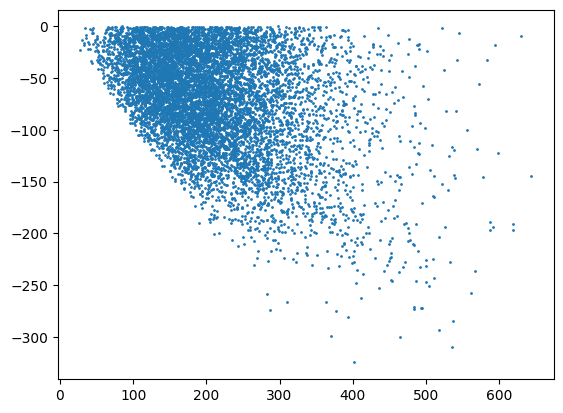

In [34]:
plt.figure()
plt.scatter(dataset_feature_list_flat['feature_1'], dataset_feature_list_flat['feature_2'], s=1)

plt.show()

In [35]:
#On calcule pour chaque phase de chaque langue le ratio token/mot 
lang_id_list = ['eng','nld','ltz','fra','spa','glg','rus','pol','mkd'];
lang_names = {
    'eng': 'Anglais',
    'nld': 'Néerlandais',
    'ltz': 'Luxembourgeois',
    'fra': 'Français',
    'spa': 'Espagnol',
    'glg': 'Galicien',
    'rus': 'Russe',
    'pol': 'Polonais',
    'mkd': 'Macédonien'
}

sentence_index = 997

all_sentences_ratios = dict()

for lang_id in lang_id_list:
    all_sentences_ratios[lang_id] = list()  # Initialisation de la liste ici

    for i in range(sentence_index):
        # Récupération de la phrase
        sentence = dataset[lang_id][i]
        # Séparation de la phrase en mots
        sentence_word_list = sentence.split()

        somme = 0
        for word in sentence_word_list:
            word_token_list = tokenizer.encode(word, add_special_tokens=False)
            somme += len(word_token_list)
        
        # On calcule le ratio token/mot pour la phrase courante
        sentence_ratio = somme / len(sentence_word_list)
        all_sentences_ratios[lang_id].append(sentence_ratio)

In [36]:
all_sentences_ratios

{'eng': [1.302325581395349,
  1.4444444444444444,
  1.8333333333333333,
  1.7777777777777777,
  1.3636363636363635,
  2.2,
  1.6153846153846154,
  1.9545454545454546,
  2.0833333333333335,
  1.3793103448275863,
  1.6666666666666667,
  1.6,
  1.2222222222222223,
  1.5333333333333334,
  1.1935483870967742,
  1.6666666666666667,
  1.5238095238095237,
  1.45,
  1.4736842105263157,
  1.173913043478261,
  1.375,
  1.5,
  1.5,
  1.5,
  1.8,
  1.6666666666666667,
  1.5945945945945945,
  2.1666666666666665,
  1.3333333333333333,
  1.6363636363636365,
  1.4,
  1.434782608695652,
  1.2272727272727273,
  1.8,
  1.65,
  1.4166666666666667,
  1.35,
  1.6818181818181819,
  1.0909090909090908,
  1.2105263157894737,
  1.5588235294117647,
  1.4285714285714286,
  1.76,
  1.7058823529411764,
  1.3636363636363635,
  2.05,
  1.85,
  1.88,
  1.7619047619047619,
  1.2954545454545454,
  1.5263157894736843,
  1.3,
  1.5666666666666667,
  1.4285714285714286,
  1.2666666666666666,
  1.5,
  1.7,
  1.66666666666666

In [37]:
data = pd.DataFrame([
    {'Ratio token/mot': ratio, 'Langue': lang_names[lang_id]}
    for lang_id, ratios in all_sentences_ratios.items()
    for ratio in ratios
])

color_discrete_map = {
    'Anglais': '#6495ED',
    'Néerlandais': '#6495ED',
    'Luxembourgeois': '#6495ED',
    'Français': '#CCCCFF',
    'Espagnol': '#CCCCFF',
    'Galicien': '#CCCCFF',
    'Russe': '#9FE2BF',
    'Polonais': '#9FE2BF',
    'Macédonien': '#9FE2BF'
}

# Créer le box plot
fig = px.box(data, y='Ratio token/mot', x='Langue', color='Langue', color_discrete_map=color_discrete_map)


# Ajouter un titre et des labels
fig.update_layout(
    title='Boites à moustaches du ratio token/mot pour les phrases des langues tokenisées',
    yaxis_title='Ratio token/mot',
    xaxis_title='Langue'
)

# Afficher le graphique
fig.show()